# Auto Insurance Claim Fraud Indicators and Classification

# Mary Donovan Martello

## The goal of this project was to identify significant features in fraudulent insurance claim transactions and to design predictive classification models to predict whether fraud was reported on the insurance claim transaction. This notebook uses a Logistic Regression model to make the fraud prediciton.

# Part 6: Logistic Regression Model

### The dataset includes 1,000 prior claim transaction records.  Each record has a mix of 38 quantitative and categorical data features about the claim filed, including information on the policy, insured, and automobile, aspects of the damage incident, and elements of the claim filed.  The dataset also has a feature that indicates whether fraud was reported on each observation (i.e., either Y or N).

In [2]:
dfClaims = pd.read_csv('FradulentInsuranceClaims.csv')

In [3]:
dfClaims.head(2)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN


### The dataset includes the original data that was cleaned, prepared, and transformed into Principal Component features in the 1_EDA_Prep notebook.

In [1]:
# import scaled, transformed and PCA df
import pandas as pd
pcaDF = pd.read_csv('pcaClaimsLog.csv')

# Model Evaluation and Model Selection

> ## Phase 3: Model Selection with Grid Search and K-Fold Cross Validation

In [7]:
# import libraries for models

import pandas as pd
import numpy as np

from numpy import mean
from numpy import std

import yellowbrick
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')


### Prepare feature matrix and target vector for pipeline modeling.

In [4]:
# separate into input and output columns (X variable for features and y for target variables)

X2 = pcaDF.drop('fraud_reported', axis = 1) 
y2 = pcaDF['fraud_reported']

# one-hot encode input variables
# use ColumnTransformer to indicate which categorical variables to encode
# https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X2)
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
                                                                        28, 29, 30, 31])], remainder='passthrough')
X2 = transformer.fit_transform(X2)

# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y2)
y2 = label_encoder.transform(y2)

### Set target class weights to address imbalance in the target

### In this project, I addressed imbalance in the target by weighting the class.  See this project for a comparison of various methods to addressed imbalanced datasets:  [Imbalance Project](https://github.com/MaryDonovanMartello/Credit-Card-Default-Imbalance-and-Deployment)

**Get the class distribution.**

In [8]:
countFraud = np.bincount(y2)
# Count occurrence of element '1' in numpy array
print('Total occurences of "1" in target: ', countFraud[1])
# Count occurrence of element '' in numpy array
print('Total occurences of "0" in target: ', countFraud[0])

Total occurences of "1" in target:  247
Total occurences of "0" in target:  751


**Use the inverse of the class distribution present for the class weighting.**

In [5]:
weights = {0:247.0, 1:751.0}

### GridSearch/Cross Validate model (all features): Logistic Regression

In [10]:
# grid search in a pipeline with logistic regression - all features

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

#Create logistic regression pipeline and gridsearch
logit = LogisticRegression(class_weight = weights)

param_logit={'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l2']}

grid = GridSearchCV(logit, param_logit, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           X2, # Feature matrix
                           y2,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([2.45638084, 2.37585545, 2.86155534, 2.37884808, 2.25357771,
       1.59088326, 1.72053719, 1.83776736, 1.38073778, 1.51240182]), 'score_time': array([0.00199533, 0.0456214 , 0.00202322, 0.01296592, 0.        ,
       0.00398874, 0.00398898, 0.        , 0.0158217 , 0.        ]), 'test_accuracy': array([0.83      , 0.82      , 0.73      , 0.82      , 0.76      ,
       0.82      , 0.81      , 0.86      , 0.84848485, 0.81818182]), 'train_accuracy': array([0.88195991, 0.87973274, 0.88530067, 0.88084633, 0.88418708,
       0.8830735 , 0.89420935, 0.88195991, 0.87764182, 0.89210234]), 'test_precision_macro': array([0.77139037, 0.74404762, 0.68317503, 0.76011029, 0.72083333,
       0.73668189, 0.69367589, 0.81428571, 0.79316888, 0.80555556]), 'train_precision_macro': array([0.835173  , 0.83330043, 0.83569413, 0.83348133, 0.83631837,
       0.83739742, 0.85160999, 0.83367459, 0.83003424, 0.84194056]), 'test_recall_macro': array([0.84387352, 0.78671329, 0.69285714, 0.8103070

### GridSearch/Cross Validate model (best subset of features): Logistic Regression

**Import best subset determined in 5_Test_Subsets_of_Features**

In [9]:
# import best subset determined in 5_Test_Subsets_of_Features
subset11 = pd.read_csv('subset11.csv')

In [16]:
# Best Subset 
# grid search in a pipeline with logistic regression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

#Create logistic regression pipeline and gridsearch
logit = LogisticRegression(class_weight = weights)

param_logit={'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l2']}

grid = GridSearchCV(logit, param_logit, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro']


pipeline=make_pipeline(grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           subset11, # Feature matrix
                           y2,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([0.67619109, 0.65624332, 0.66821551, 0.70710349, 0.50863576,
       0.52858448, 0.51561975, 0.48570013, 0.3624692 , 0.35268331]), 'score_time': array([0.00997233, 0.01197195, 0.00797606, 0.02095389, 0.00698042,
       0.00598359, 0.00797987, 0.00598359, 0.01562166, 0.        ]), 'test_accuracy': array([0.78      , 0.84      , 0.79      , 0.85      , 0.81      ,
       0.85      , 0.81      , 0.89      , 0.8989899 , 0.86868687]), 'train_accuracy': array([0.84521158, 0.83853007, 0.844098  , 0.83741648, 0.84187082,
       0.83741648, 0.84187082, 0.83296214, 0.8320356 , 0.83537264]), 'test_precision_macro': array([0.70733988, 0.77142857, 0.75851198, 0.79237494, 0.77573377,
       0.77390852, 0.7       , 0.84922861, 0.85387324, 0.85869565]), 'train_precision_macro': array([0.79223919, 0.7850208 , 0.78674294, 0.78284894, 0.78605918,
       0.78459192, 0.79124238, 0.77646337, 0.77655264, 0.77581064]), 'test_recall_macro': array([0.75042349, 0.83216783, 0.79285714, 0.8300438

### Prediction with best subset of features

In [10]:
# now make a prediction with subset of features
# Try cross=validation predict
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

#Create logistic regression pipeline and gridsearch
logit = LogisticRegression(class_weight = weights)

param_logit={'C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'penalty': ['l2']}

grid = GridSearchCV(logit, param_logit, cv=5, verbose=0)

# create a pipeline that standardizes, then runs logistic regression
pipeline=make_pipeline(grid)

# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)

# conduct a k-fold cross-validation and a prediction
predLogS11=cross_val_predict(pipeline, # Pipeline
                           subset11, # Feature matrix
                           y2,#target vector
                           cv=kf, # Cross-validation technique
                           n_jobs = -1)

### Confusion Matix - Logistic Regression

In [18]:

from sklearn.metrics import confusion_matrix
conf_matLR = confusion_matrix(y2, predLogS11)
print(conf_matLR)

[[639 112]
 [ 49 198]]


### Classification Report - Logistic Regression

<AxesSubplot:>

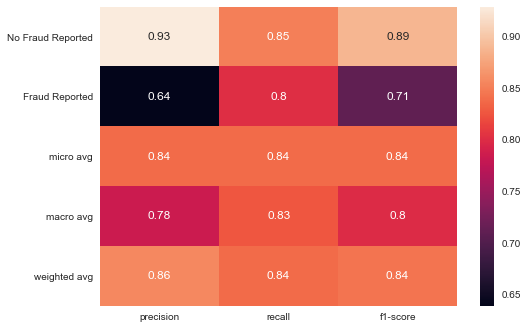

In [11]:
from sklearn.metrics import classification_report
class_repLR = classification_report(y2, predLogS11, output_dict=True, target_names= ['No Fraud Reported', 'Fraud Reported'])

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
# Create a dataframe from the dictionary and plot a heatmap of it.
import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_repLR).iloc[:-1, :].T, annot=True)